<a id='top'></a>
# Analyse exploratoire de la base de donnée destinée à la conception du modèle de machine learning (Données Agrégées)

## Sommaire
<a href='#section1'> 1. Librairies et importation</a> <br/>
<a href='#section2'> 2. Agregation des données par blocks</a> <br/>
<a href='#section3'> 3. Extraction de caractéristiques</a> <br/>
<a href='#section4'> 4. Echantionnage</a> <br/>
<a href='#section5'> 5. LightGBM</a> <br/>
&nbsp;&nbsp;&nbsp; <a href='#section5.1'> 5.1 Split test train X Y</a> <br/>
&nbsp;&nbsp;&nbsp; <a href='#section5.2'> 5.2 Classifieur naïf</a> <br/>
&nbsp;&nbsp;&nbsp; <a href='#section5.3'> 5.3 Tables de confusion</a> <br/>
&nbsp;&nbsp;&nbsp; <a href='#section5.4'> 5.4 Importance des variabes</a> <br/>
<a href='#section6'> 6. Modèle V1 LightGBM</a> <br/>
&nbsp;&nbsp;&nbsp; <a href='#section6.1'> 6.1 Extraction des caractéristiques</a> <br/>
&nbsp;&nbsp;&nbsp; <a href='#section6.2'> 6.2 Split test train X Y</a> <br/>
&nbsp;&nbsp;&nbsp; <a href='#section6.3'> 6.3 Classifieur</a> <br/>
&nbsp;&nbsp;&nbsp; <a href='#section6.4'> 6.4 Tables de confusion</a> <br/>
&nbsp;&nbsp;&nbsp; <a href='#section6.5'> 6.5 Importance des variabes</a> <br/>

<a id='section1'></a>
# 1. librairies et importation
<a href='#top'> Sommaire</a> <br/>

In [1]:
# importations des librairies
import numpy as np
import pandas as pd
import sqlite3
from sqlalchemy import create_engine
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import tsfresh
import time
import lightgbm
import sklearn

In [2]:
# versions
print("numpy",np.version.version)
print("pandas",pd.__version__)
print("sqlite3",sqlite3.sqlite_version)
print("matplotlib",matplotlib.__version__)
print("seaborn",sns.__version__)
print("tsfresh",tsfresh.__version__)
print("lightgbm",lightgbm.__version__)
print("sklearn",sklearn.__version__)

numpy 1.16.2
pandas 0.23.4
sqlite3 3.26.0
matplotlib 3.0.2
seaborn 0.9.0
tsfresh 0.11.2
lightgbm 2.2.1
sklearn 0.20.2


In [3]:
# chemin
path = ''

In [4]:
# Dictionaire du type des variables pour l'importation
l_types_df_paquets = {'id_brut': 'int32'
                      , 'Time_Debut': 'int32'
                      , 'Accelero_x': 'float32'
                      , 'Accelero_y': 'float32'
                      , 'Accelero_z': 'float32'
                      , 'Gyro_x': 'float32'
                      , 'Gyro_y': 'float32'
                      , 'Gyro_z': 'float32'
                      , 'Magn_norm': 'float32'
#                       , 'Dogs': pd.CategoricalDtype(categories=['Ambre', 'Athos', 'Babette', 'Baila', 'Belle', 'Canelle',
#                    'Cookie1', 'Curtis', 'Diesel', 'Eliot', 'Eva2', 'Eva3',
#                    'Falcor', 'Filousse', 'Fly', 'Gaia', 'Gatchan', 'Gribouille',
#                    'Gwen', 'Helmo', 'Hooper', 'Huston', 'Ines', 'Irish', 'Joey',
#                    'Joy', 'Jules', 'Kira', 'Kloug', 'Loki', 'Loly', 'Loop',
#                    'Louina', 'Louxor', 'Lutti', 'Maiko', 'Marley', 'Melka',
#                    'Mia', 'Monroe', 'Mya', 'Nala', 'Neptune', 'Nil', 'Nissa',
#                    'Nobel', 'Oko', 'Padi', 'Papy', 'Promesse', 'Raoul', 'Rex2',
#                    'Rex3', 'Shadow', 'Sky', 'SonicC', 'Yuna'], ordered=False)
#                       , 'Behaviour': pd.CategoricalDtype(categories=['Boire', 'Courir', 'Immobile', 'Inconnu', 'Manger',
#                    'Marcher', 'Renifler', 'SeGratter', 'SeLecher', 'SeSecouer',
#                    'Trotter'], ordered=False)
                      , 'c_chien': 'bool'
                      , 'c_beh': 'bool'
                      , 'ecart': 'int32'
                      , 'double_label': 'bool'
#                       , 'agr_ecart': pd.CategoricalDtype(categories=['-1', '100<ecart', '10<ecart<=15', '15<ecart<=20',
#                    '20<ecart<=30', '2<ecart<=4', '30<ecart<=40', '40<ecart<=50',
#                    '4<ecart<=6', '50<ecart<=100', '6<ecart<=8', '8<ecart<=10',
#                    'ecart=2'],  ordered=False)
                      , 'block': 'int32'}

In [5]:
df_paquets = pd.read_csv(path + 'Data_collar_dogs_New_paquets.csv', dtype=l_types_df_paquets)
df_paquets['Dogs'] = df_paquets['Dogs'].astype('category')
df_paquets['agr_ecart'] = df_paquets['agr_ecart'].astype('category')
df_paquets['Behaviour'] = df_paquets['Behaviour'].astype('category')

In [6]:
df_paquets.head()

id_brut  Time_Debut  Accelero_x  Accelero_y  Accelero_z  Gyro_x  Gyro_y  \
0        0        5808      0.6860     -3.7422     -1.6187  0.5786 -1.5466   
1        1        5810      0.3237      4.4287     -0.5830  2.2310  0.2119   
2        2        5812      0.0291      1.3005     -4.0383  3.7520  0.2861   
3        3        5814      1.4011     -2.9844     -1.2654  3.4978 -0.2866   
4        4        5816      0.6138      6.2617     -0.2495  2.0527  1.4062   

   Gyro_z  Magn_norm   Dogs  Behaviour  c_chien  c_beh  ecart  double_label  \
0 -1.1536     0.1967  Ambre  SeSecouer    False  False     -1         False   
1  0.2236     0.2025  Ambre  SeSecouer     True   True      2         False   
2  0.0110     0.2025  Ambre  SeSecouer     True   True      2         False   
3 -0.6541     0.2025  Ambre  SeSecouer     True   True      2         False   
4 -0.8306     0.2025  Ambre  SeSecouer     True   True      2         False   

  agr_ecart  block  
0        -1      0  
1   ecart=2      0  
2   ecart=2      0  
3   ecart=2      0  
4   ecart=2      0

<a id='section2'></a>
# 2. Agregation des données par blocks
<a href='#top'> Sommaire</a> <br/>

In [7]:
df = df_paquets.drop(["id_brut","Time_Debut","c_chien","c_beh","ecart","double_label","agr_ecart"],axis=1)
df = df[df["block"]!=0]

In [8]:
df.head()

Accelero_x  Accelero_y  Accelero_z  Gyro_x  Gyro_y  Gyro_z  Magn_norm  \
48     -0.1282      0.8206     -0.5603  0.0747 -0.4109  0.0366     0.1630   
49      0.0681      0.7458     -0.4514 -0.0271 -0.5642  0.0479     0.1630   
50      0.3020      0.5540     -0.4541 -0.1577 -0.5544  0.0100     0.1630   
51      0.2637      0.5332     -0.5266 -0.1199 -0.4409  0.0210     0.1758   
52      0.1665      0.5598     -0.5554 -0.0764 -0.3391  0.0706     0.1758   

     Dogs Behaviour  block  
48  Ambre   Marcher     61  
49  Ambre   Marcher     61  
50  Ambre   Marcher     61  
51  Ambre   Marcher     61  
52  Ambre   Marcher     61

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1056300 entries, 48 to 1190796
Data columns (total 10 columns):
Accelero_x    1056300 non-null float32
Accelero_y    1056300 non-null float32
Accelero_z    1056300 non-null float32
Gyro_x        1056300 non-null float32
Gyro_y        1056300 non-null float32
Gyro_z        1056300 non-null float32
Magn_norm     1056300 non-null float32
Dogs          1056300 non-null category
Behaviour     1056300 non-null category
block         1056300 non-null int32
dtypes: category(2), float32(7), int32(1)
memory usage: 42.3 MB


#### Regroupons toutes les informations d'un meme block :

In [10]:
# taille des blocks
nb=sum(df["block"]==1)

In [11]:
def groupe_par_block_var(df,nb,var):
    
    # liste des valeurs d'une variable d'un meme block
    liste = tsfresh.feature_extraction.extraction.generate_data_chunk_format(df, "block", "block", var)
    
    # liste des nouvelles colonnes
    liste_colonnes = []
    for i in range(1,nb+1):
        liste_colonnes.append(var + " " + str(i))
    df_sortie = pd.DataFrame(columns=liste_colonnes)
    
    # remplit le dataframe
    for block in range(len(liste)):
        df_sortie.loc[len(df_sortie)] = list(liste[block][2])

    return(df_sortie)

In [12]:
def groupe_par_block(df,nb):
    
    # dataframe avec les ids (block,chien,comportement)
    df.loc[:,"Dogs"] = df.loc[:,"Dogs"].astype('object')
    df.loc[:,"Behaviour"] = df.loc[:,"Behaviour"].astype('object')
    grp_by = df[['block','Dogs','Behaviour']].groupby(['block','Dogs','Behaviour'])
    df_sortie = grp_by.count()
    df_sortie.reset_index(inplace=True)
    
    # concatenation du dataframe avec les valaurs des variables par block
    liste_var = ['Accelero_x','Accelero_y','Accelero_z','Gyro_x','Gyro_y','Gyro_z','Magn_norm']
    for var in liste_var:
        print(var)
        df_temp = groupe_par_block_var(df,nb,var)
        df_sortie = pd.merge(df_sortie, df_temp, left_index=True, right_index=True, how='inner')
        
    return(df_sortie)

In [13]:
#df_block = groupe_par_block(df,nb)

In [14]:
#df_block.head()

#### Export

In [15]:
# csv
#df_block.to_csv("Data_collar_dogs_New_parblock.csv",index=False)

#### Import

In [16]:
# csv
df_block = pd.read_csv("Data_collar_dogs_New_parblock.csv")

In [17]:
df_block.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21126 entries, 0 to 21125
Columns: 353 entries, block to Magn_norm 50
dtypes: float64(350), int64(1), object(2)
memory usage: 56.9+ MB


In [18]:
# dtypes des variables
df_block.loc[:,"block"] = df_block.loc[:,"block"].astype(np.int16)
df_block.loc[:,["Dogs","Behaviour"]] = df_block.loc[:,["Dogs","Behaviour"]].astype('category')
df_block.iloc[:,3:df_block.shape[1]] = df_block.iloc[:,3:df_block.shape[1]].astype(np.float32)

In [19]:
df_block.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21126 entries, 0 to 21125
Columns: 353 entries, block to Magn_norm 50
dtypes: category(2), float32(350), int16(1)
memory usage: 28.3 MB


In [20]:
df_block.head()

block   Dogs  Behaviour  Accelero_x 1  Accelero_x 2  Accelero_x 3  \
0      1  Ambre  SeSecouer        0.5454       -2.2625       -1.1348   
1      2  Athos  SeSecouer       -4.7131       -4.6013        7.9998   
2      3  Athos  SeSecouer       -0.4067       -5.7207       -0.2791   
3      4  Baila  SeSecouer        3.3552        0.7681       -0.7959   
4      5  Belle  SeSecouer        2.8372        2.8105       -2.4404   

   Accelero_x 4  Accelero_x 5  Accelero_x 6  Accelero_x 7      ...       \
0       -0.7451        0.8237        1.3342       -0.3645      ...        
1        0.3655        0.2297       -2.3533       -4.4595      ...        
2        3.0872        1.5249        1.1997       -6.2507      ...        
3       -2.8420       -1.7751        0.1208        0.9861      ...        
4       -5.0876       -4.8635       -0.7910        3.5027      ...        

   Magn_norm 41  Magn_norm 42  Magn_norm 43  Magn_norm 44  Magn_norm 45  \
0        0.2076        0.2076        0.2076        0.2133        0.2133   
1        0.0050        0.0025        0.0072        0.0174        0.0113   
2        0.0181        0.0215        0.0225        0.0194        0.0125   
3        0.0706        0.0715        0.0708        0.0687        0.0713   
4        0.1066        0.1218        0.1218        0.1288        0.1718   

   Magn_norm 46  Magn_norm 47  Magn_norm 48  Magn_norm 49  Magn_norm 50  
0        0.2133        0.2133        0.1453        0.2181        0.1929  
1        0.0223        0.0183        0.0142        0.0097        0.0166  
2        0.0059        0.0047        0.0032        0.0072        0.0119  
3        0.0689        0.0693        0.0701        0.0705        0.0683  
4        0.1952        0.1952        0.1571        0.1952        0.1571  

[5 rows x 353 columns]

Prenons un block en particulier et calculons manuellement certaines caractéristiques pour par la suite vérifier si les blocks n'ont pas été inversés.

In [152]:
df_block.loc[df_block["block"]==2019]

block  Dogs Behaviour  Accelero_x 1  Accelero_x 2  Accelero_x 3  \
2018   2019  Nala   Marcher       -0.1882        -0.259       -0.7356   

      Accelero_x 4  Accelero_x 5  Accelero_x 6  Accelero_x 7      ...       \
2018        -0.575        -0.114       -0.0076        0.0569      ...        

      Magn_norm 41  Magn_norm 42  Magn_norm 43  Magn_norm 44  Magn_norm 45  \
2018        0.1369        0.1369        0.1312        0.1312        0.1312   

      Magn_norm 46  Magn_norm 47  Magn_norm 48  Magn_norm 49  Magn_norm 50  
2018        0.1312        0.1351        0.1369        0.1207        0.1207  

[1 rows x 353 columns]

In [157]:
block_test_2019 = df_block.loc[df_block["block"]==2019]

acc_x_test_2019 = block_test_2019.iloc[:,3:53]
acc_y_test_2019 = block_test_2019.iloc[:,53:103]
acc_z_test_2019 = block_test_2019.iloc[:,103:153]
gyro_x_test_2019 = block_test_2019.iloc[:,153:203]
gyro_y_test_2019 = block_test_2019.iloc[:,203:253]
gyro_z_test_2019 = block_test_2019.iloc[:,253:303]
Magn_norm_test_2019 = block_test_2019.iloc[:,303:353]

acc_x_test_2019_mean = acc_x_test_2019.mean(axis = 1)
gyro_y_test_2019_min = gyro_y_test_2019.min(axis = 1)
Magn_norm_test_2019_max = Magn_norm_test_2019.max(axis = 1)

print("acc_x_test_2019_mean",acc_x_test_2019_mean)
print("gyro_y_test_2019_min",gyro_y_test_2019_min)
print("Magn_norm_test_2019_max",Magn_norm_test_2019_max)

acc_x_test_2019_mean 2018   -0.206318
dtype: float32
gyro_y_test_2019_min 2018   -0.3906
dtype: float32
Magn_norm_test_2019_max 2018    0.1466
dtype: float32


<a id='section3'></a>
# 3. Extraction de caractéristiques
<a href='#top'> Sommaire</a> <br/>

Avant d'extraire les caractéristiques on enlève les colonnes non utiles ainsi que les lignes n'appartenant pas à un block.

In [21]:
df_series = df_paquets.drop(["id_brut","c_chien","c_beh","ecart","double_label","agr_ecart","Dogs","Behaviour"],axis=1)
df_series = df_series[df_series["block"]!=0]

In [22]:
df_series.head()

Time_Debut  Accelero_x  Accelero_y  Accelero_z  Gyro_x  Gyro_y  Gyro_z  \
48        5904     -0.1282      0.8206     -0.5603  0.0747 -0.4109  0.0366   
49        5906      0.0681      0.7458     -0.4514 -0.0271 -0.5642  0.0479   
50        5908      0.3020      0.5540     -0.4541 -0.1577 -0.5544  0.0100   
51        5910      0.2637      0.5332     -0.5266 -0.1199 -0.4409  0.0210   
52        5912      0.1665      0.5598     -0.5554 -0.0764 -0.3391  0.0706   

    Magn_norm  block  
48     0.1630     61  
49     0.1630     61  
50     0.1630     61  
51     0.1758     61  
52     0.1758     61

In [23]:
df_series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1056300 entries, 48 to 1190796
Data columns (total 9 columns):
Time_Debut    1056300 non-null int32
Accelero_x    1056300 non-null float32
Accelero_y    1056300 non-null float32
Accelero_z    1056300 non-null float32
Gyro_x        1056300 non-null float32
Gyro_y        1056300 non-null float32
Gyro_z        1056300 non-null float32
Magn_norm     1056300 non-null float32
block         1056300 non-null int32
dtypes: float32(7), int32(2)
memory usage: 44.3 MB


Fonction qui va extraire les caractéristiques de chaque block et les stocker dans un ficher csv :

In [24]:
def extract_features_by_part(df,nb_part):
    nb_block = df["block"].max()
    for i in range(nb_part):
        print(i/nb_part)
        block_min = int(i*nb_block/nb_part)
        block_max = int((i+1)*nb_block/nb_part)
        print(block_min,block_max)
        df_temp = df[np.logical_and(block_min<df["block"],df["block"]<=block_max)]
        extracted_features = tsfresh.extract_features(df_temp, column_id="block", column_sort="Time_Debut")
        if (i==0):
            extracted_features.to_csv('Data_collar_block_extracted_features.csv', mode='w', index=False)
        else:
            extracted_features.to_csv('Data_collar_block_extracted_features.csv', mode='a', header=False, index=False)

In [25]:
#extract_features_by_part(df_series,9)

### Import

In [26]:
df_types = pd.read_csv("Data_collar_block_extracted_features.csv",nrows=100)
float_cols = [c for c in df_types if df_types[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}
df_fe = pd.read_csv("Data_collar_block_extracted_features.csv", dtype=float32_cols)

In [27]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21126 entries, 0 to 21125
Columns: 5558 entries, Accelero_x__abs_energy to Magn_norm__variance_larger_than_standard_deviation
dtypes: float32(5558)
memory usage: 447.9 MB


In [28]:
df_fe.head()

Accelero_x__abs_energy  Accelero_x__absolute_sum_of_changes  \
0               31.749683                            31.736898   
1              545.887939                           181.237701   
2              644.686462                           205.148087   
3               73.066765                            61.517399   
4              464.644165                           144.571091   

   Accelero_x__agg_autocorrelation__f_agg_"mean"__maxlag_40  \
0                                           0.014211          
1                                          -0.026575          
2                                          -0.007608          
3                                          -0.028263          
4                                          -0.010456          

   Accelero_x__agg_autocorrelation__f_agg_"median"__maxlag_40  \
0                                          -0.041045            
1                                           0.013997            
2                                          -0.044321            
3                                          -0.053283            
4                                           0.023338            

   Accelero_x__agg_autocorrelation__f_agg_"var"__maxlag_40  \
0                                           0.068896         
1                                           0.051557         
2                                           0.038955         
3                                           0.026867         
4                                           0.062574         

   Accelero_x__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"  \
0                                            1.15092                           
1                                            5.95272                           
2                                            4.19500                           
3                                            2.58788                           
4                                            4.05156                           

   Accelero_x__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"  \
0                                          -0.032709                        
1                                          -0.030904                        
2                                           0.433193                        
3                                          -0.732946                        
4                                           0.132453                        

   Accelero_x__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"  \
0                                           -0.01172                       
1                                           -0.03936                       
2                                            0.64624                       
3                                           -0.54875                       
4                                            0.21839                       

   Accelero_x__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"  \
0                                           0.206760                        
1                                           0.734973                        
2                                           0.776285                        
3                                           0.294059                        
4                                           0.943555                        

   Accelero_x__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"  \
0                                                NaN                           
1                                                NaN                           
2                                                NaN                           
3                                                NaN                           
4                                                NaN                           

                          ...                          \
0                         ...                           
1   

On remet les labels, chiens et blocks dans la dataframe :

In [29]:
df_paquets.loc[:,"Dogs"] = df_paquets.loc[:,"Dogs"].astype('object')
df_paquets.loc[:,"Behaviour"] = df_paquets.loc[:,"Behaviour"].astype('object')
grp_by = df_paquets[['block','Dogs','Behaviour']].groupby(['block','Dogs','Behaviour'])
df_id = grp_by.count()
df_id.reset_index(inplace=True)
df_id = df_id[df_id["block"]!=0]
df_id.reset_index(inplace=True,drop=True)

In [30]:
df_id.head()

block   Dogs  Behaviour
0      1  Ambre  SeSecouer
1      2  Athos  SeSecouer
2      3  Athos  SeSecouer
3      4  Baila  SeSecouer
4      5  Belle  SeSecouer

In [31]:
df_all_fe = pd.merge(df_id, df_fe, left_index=True, right_index=True, how='inner')

In [32]:
df_all_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21126 entries, 0 to 21125
Columns: 5561 entries, block to Magn_norm__variance_larger_than_standard_deviation
dtypes: float32(5558), int64(1), object(2)
memory usage: 448.4+ MB


In [33]:
df_all_fe.head()

block   Dogs  Behaviour  Accelero_x__abs_energy  \
0      1  Ambre  SeSecouer               31.749683   
1      2  Athos  SeSecouer              545.887939   
2      3  Athos  SeSecouer              644.686462   
3      4  Baila  SeSecouer               73.066765   
4      5  Belle  SeSecouer              464.644165   

   Accelero_x__absolute_sum_of_changes  \
0                            31.736898   
1                           181.237701   
2                           205.148087   
3                            61.517399   
4                           144.571091   

   Accelero_x__agg_autocorrelation__f_agg_"mean"__maxlag_40  \
0                                           0.014211          
1                                          -0.026575          
2                                          -0.007608          
3                                          -0.028263          
4                                          -0.010456          

   Accelero_x__agg_autocorrelation__f_agg_"median"__maxlag_40  \
0                                          -0.041045            
1                                           0.013997            
2                                          -0.044321            
3                                          -0.053283            
4                                           0.023338            

   Accelero_x__agg_autocorrelation__f_agg_"var"__maxlag_40  \
0                                           0.068896         
1                                           0.051557         
2                                           0.038955         
3                                           0.026867         
4                                           0.062574         

   Accelero_x__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"  \
0                                            1.15092                           
1                                            5.95272                           
2                                            4.19500                           
3                                            2.58788                           
4                                            4.05156                           

   Accelero_x__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"  \
0                                          -0.032709                        
1                                          -0.030904                        
2                                           0.433193                        
3                                          -0.732946                        
4                                           0.132453                        

                          ...                          \
0                         ...                           
1                         ...                           
2                         ...                           
3                         ...                           
4                         ...                           

   Magn_norm__symmetry_looking__r_0.9  \
0                                 1.0   
1                                 1.0   
2                                 1.0   
3                                 1.0   
4                                 1.0   

   Magn_norm__symmetry_looking__r_0.9500000000000001  \
0                                                1.0   
1                                                1.0   
2                                                1.0   
3                                                1.0   
4                                                1.0   

   Magn_norm__time_reversal_asymmetry_statistic__lag_1  \
0                                      -7.479452e-06     
1                                       1.262293e-07     
2                                      -3.928464e-08     
3                                      -4.941588e-10     
4                                       1.287089e-04     

   Magn_norm__time_reversal_asymmetry_statistic__lag_2  \
0   

In [34]:
# dtypes des variables
df_all_fe.loc[:,"block"] = df_all_fe.loc[:,"block"].astype(np.int16)
df_paquets.loc[:,"Dogs"] = df_paquets.loc[:,"Dogs"].astype('category')
df_paquets.loc[:,"Behaviour"] = df_paquets.loc[:,"Behaviour"].astype('category')

In [35]:
df_all_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21126 entries, 0 to 21125
Columns: 5561 entries, block to Magn_norm__variance_larger_than_standard_deviation
dtypes: float32(5558), int16(1), object(2)
memory usage: 448.3+ MB


In [36]:
print("On a extrait %i caractéristiques par signal." % ((df_all_fe.shape[1]-3)/7))

On a extrait 794 caractéristiques par signal.


Vérification si les block n'ont pas été permutés :

In [180]:
df_all_fe.columns[709:716]

Index(['Accelero_x__maximum', 'Accelero_x__mean',
       'Accelero_x__mean_abs_change', 'Accelero_x__mean_change',
       'Accelero_x__mean_second_derivative_central', 'Accelero_x__median',
       'Accelero_x__minimum'],
      dtype='object')

In [182]:
print("Accelero_x__mean",df_all_fe.loc[2019-1,"Accelero_x__mean"])
print("Gyro_y__minimum",df_all_fe.loc[2019-1,"Gyro_y__minimum"])
print("Magn_norm__maximum",df_all_fe.loc[2019-1,"Magn_norm__maximum"])

Accelero_x__mean -0.20631799
Gyro_y__minimum -0.3906
Magn_norm__maximum 0.1466


In [183]:
print("acc_x_test_2019_mean",acc_x_test_2019_mean)
print("gyro_y_test_2019_min",gyro_y_test_2019_min)
print("Magn_norm_test_2019_max",Magn_norm_test_2019_max)

acc_x_test_2019_mean 2018   -0.206318
dtype: float32
gyro_y_test_2019_min 2018   -0.3906
dtype: float32
Magn_norm_test_2019_max 2018    0.1466
dtype: float32


<a id='section4'></a>
# 4. Echantionnage
<a href='#top'> Sommaire</a> <br/>

Notre table de carctéristiques est faite, il nous faut maintenant faire une sélection de variable.

Fonction qui permet de prendre un échantillon de la base :

In [204]:
# df : base de donnée que l'on souhaite échantilloner
# var : variable de df où l'on souhaite garder les proportions (stratification)
# pct : pourcentage de la base en sortie par rapport à la base en entrée
def echantillon(df,var,pct):
    premier = True
    for beh in df_all_fe[var].unique():
        df_beh = df_all_fe[df_all_fe[var]==beh]
        df_temp = df_beh.sample(frac = pct)
        if (premier == True):
            df_sortie = df_temp
            premier = False
        else:
            df_sortie = df_sortie.append(df_temp, ignore_index=True)
    return (df_sortie)

In [202]:
df_sample = echantillon(df_all_fe,"Behaviour",0.1)

<a id='section5'></a>
# 5. LightGBM
<a href='#top'> Sommaire</a>

<a id='section5.1'></a>
## 5.1 Split test train X Y
<a href='#top'> Sommaire</a>

In [ ]:
Train, Test = sklearn.model_selection.train_test_split(df_all_fe, test_size=0.2, stratify=df_all_fe["Behaviour"])

In [207]:
XTrain = Train.iloc[:,3:df_sample.shape[1]]
YTrain = Train["Behaviour"]

XTest = Test.iloc[:,3:df_sample.shape[1]]
YTest = Test["Behaviour"]

<a id='section5.2'></a>
## 5.2 Classifieur naïf
<a href='#top'> Sommaire</a>

On construit un classifieur naïf avec lightGBM et les paramètres de base et toutes les caractéristiques :

In [41]:
# construction du classifieur
class_lgb = lightgbm.LGBMClassifier()
class_lgb.fit(XTrain,YTrain)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Testons ce classifieur sur notre base de test :

In [42]:
# prédiction de l'échantillon test
YPred = class_lgb.predict(XTest)

# taux d'erreur de l'échantillon test
TestError = np.mean(YTest!=YPred)
print("le taux d'erreur est",TestError)

le taux d'erreur est 0.21131093232371037


<a id='section5.3'></a>
## 5.3 Tables de confusion
<a href='#top'> Sommaire</a>

Pour afficher la table de confusion on récupère l'ordre des labels

In [44]:
# table de confusion
Table = sklearn.metrics.confusion_matrix(YTest,YPred)
#print("la table de confusion est\n",Table)

row_sums = Table.sum(axis=1)
Table_normal = Table / row_sums[:, np.newaxis]
#print("la table de confusion est\n",Table_normal)

print("L'ordre des labels est bien récupéré :",(np.unique(YPred, return_counts=True)[1] == np.sum(Table,axis=0)).all())
labels = np.unique(YPred).astype('<U10')
print(labels)

L'ordre des labels est bien récupéré : True
['Boire' 'Courir' 'Immobile' 'Inconnu' 'Manger' 'Marcher' 'Renifler'
 'SeGratter' 'SeLecher' 'SeSecouer' 'Trotter']


Text(69.0, 0.5, 'Labélisé')

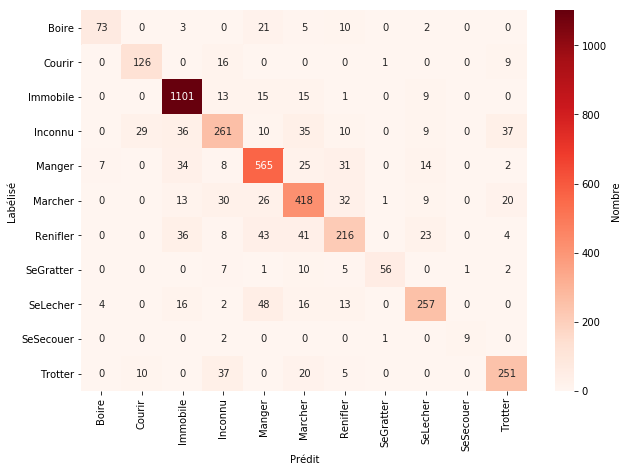

In [45]:
df_cm = pd.DataFrame(Table, index = labels, columns = labels)
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt='g', cmap="Reds")
ax.collections[0].colorbar.set_label("Nombre")
plt.xlabel('Prédit')
plt.ylabel('Labélisé')

Text(69.0, 0.5, 'Labélisé')

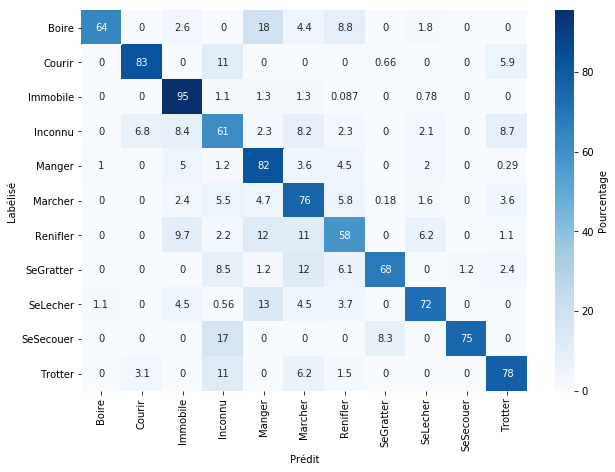

In [46]:
df_cm = pd.DataFrame(100*Table_normal, index = labels, columns = labels)
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap="Blues")
ax.collections[0].colorbar.set_label("Pourcentage")
plt.xlabel('Prédit')
plt.ylabel('Labélisé')

In [47]:
taux_erreur_non_pondere = 100-sum(np.diagonal(100*Table_normal))/Table_normal.shape[0]
print("Sans tenir compte du poids de chaque label l'erreur est de : %.2f pourcent." %(taux_erreur_non_pondere))

Sans tenir compte du poids de chaque label l'erreur est de : 26.06 pourcent.


<a id='section5.4'></a>
## 5.4 Importance des variabes
<a href='#top'> Sommaire</a> <br/>

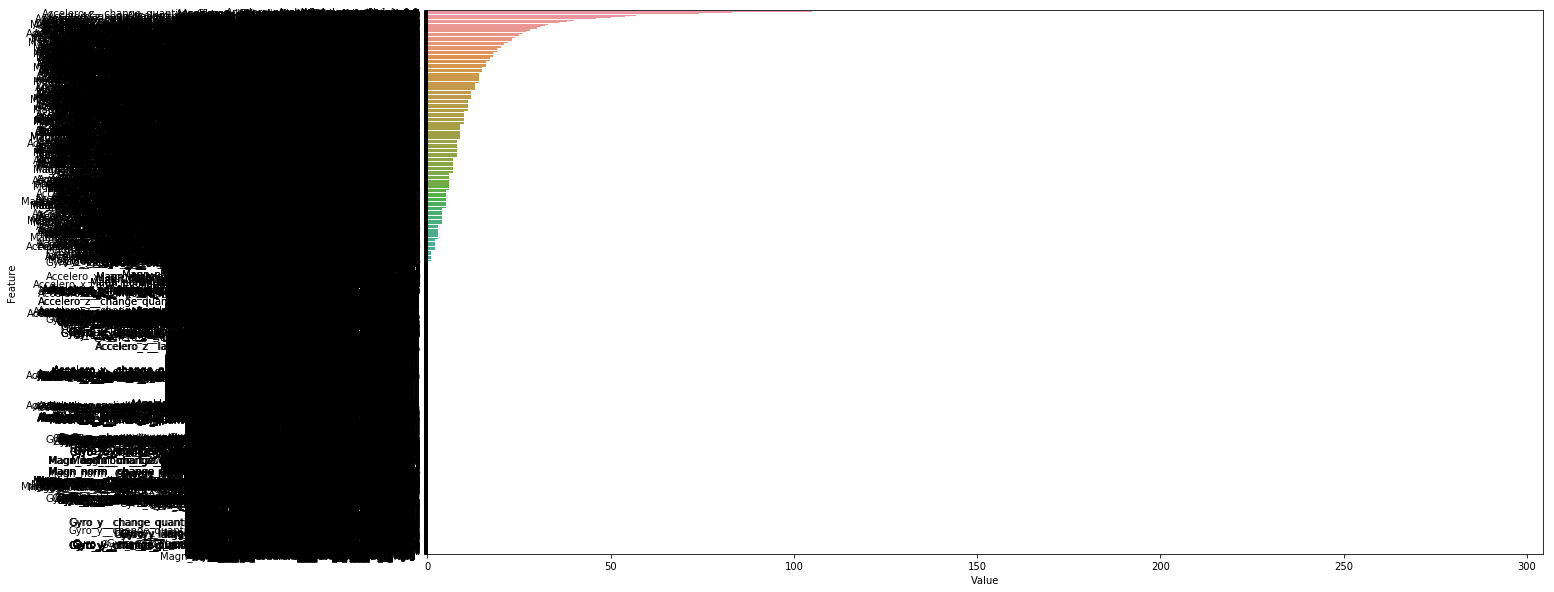

In [51]:
feature_imp = pd.DataFrame(sorted(zip(class_lgb.feature_importances_,XTrain.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))

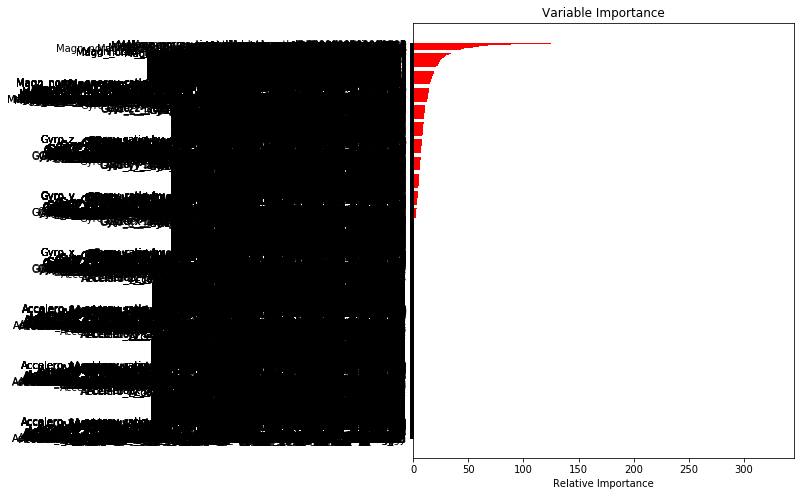

In [290]:
feature_importance = sorted(class_lgb.feature_importances_)
# make importances relative to max importance
pos = np.linspace(1, XTrain.shape[1], XTrain.shape[1]) + .5
fig = plt.figure(1, figsize=(15, 8))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance, color='r', align='center')
plt.yticks(pos, list(XTrain))
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [65]:
print("nombre de caratéristiques avec une importance nulle : %i" % (feature_imp[feature_imp["Value"]==0].shape[0]))
print("nombre de caratéristiques avec une importance non nulle : %i" % (feature_imp[feature_imp["Value"]!=0].shape[0]))

nombre de caratéristiques avec une importance nulle : 2990
nombre de caratéristiques avec une importance non nulle : 2568


In [72]:
feature_imp = pd.DataFrame(sorted(zip(class_lgb.feature_importances_,XTrain.columns),reverse=True), columns=['Value','Feature'])

In [80]:
feature_imp.head(20)

Value                                            Feature
0     290                                Accelero_x__minimum
1     186                                 Magn_norm__minimum
2     173                        Accelero_x__quantile__q_0.1
3     166                Accelero_z__absolute_sum_of_changes
4     163                             Accelero_y__abs_energy
5     153                 Accelero_z__autocorrelation__lag_2
6     151                                 Gyro_z__abs_energy
7     141                                 Magn_norm__maximum
8     133                                Accelero_x__maximum
9     123  Accelero_z__change_quantiles__f_agg_"mean"__is...
10    110   Accelero_y__fft_coefficient__coeff_0__attr_"abs"
11    108     Accelero_x__fft_aggregated__aggtype_"centroid"
12    106                        Accelero_z__quantile__q_0.9
13    105         Gyro_x__fft_aggregated__aggtype_"kurtosis"
14    103                        Accelero_x__quantile__q_0.2
15    101          Accelero_x__ar_coefficient__k_10__coeff_0
16    100   Accelero_x__fft_coefficient__coeff_0__attr_"abs"
17     92                        Accelero_x__quantile__q_0.3
18     89                      Accelero_z__number_peaks__n_1
19     88                                Accelero_z__maximum

In [81]:
feature_imp[feature_imp["Value"]>25].shape[0]

243

<a id='section6'></a>
# 6. Modèle V1 LightGBM
<a href='#top'> Sommaire</a> <br/>

Reconstruction du modèle usilisé pour la V1, au détail près que l'on a que des blocks propre de 50 dans la base.

<a id='section6.1'></a>
## 6.1 Extraction des caractéristiques
<a href='#top'> Sommaire</a> <br/>

In [103]:
parametres_V1 = {
     "mean": None
    ,"median": None
    ,"minimum" : None
    ,"maximum" : None
    ,"standard_deviation" : None
    ,"skewness" : None
    ,"kurtosis" : None
    ,"quantile" : [{"q":0.25}, {"q":0.75}]
}

In [104]:
xtracted_features = tsfresh.extract_features(df_series, column_id="block", column_sort="Time_Debut", default_fc_parameters=parametres_V1)



Feature Extraction:   0%|          | 0/20 [00:00<?, ?it/s]

Feature Extraction:   5%|▌         | 1/20 [00:08<02:47,  8.81s/it]

Feature Extraction:  10%|█         | 2/20 [00:09<01:54,  6.37s/it]

Feature Extraction:  15%|█▌        | 3/20 [00:10<01:19,  4.66s/it]

Feature Extraction:  20%|██        | 4/20 [00:11<00:57,  3.59s/it]

Feature Extraction:  25%|██▌       | 5/20 [00:16<01:02,  4.14s/it]

Feature Extraction:  30%|███       | 6/20 [00:17<00:44,  3.20s/it]

Feature Extraction:  35%|███▌      | 7/20 [00:18<00:31,  2.45s/it]

Feature Extraction:  40%|████      | 8/20 [00:19<00:23,  1.99s/it]

Feature Extraction:  45%|████▌     | 9/20 [00:24<00:32,  2.97s/it]

Feature Extraction:  50%|█████     | 10/20 [00:25<00:23,  2.38s/it]

Feature Extraction:  55%|█████▌    | 11/20 [00:26<00:17,  1.98s/it]

Feature Extraction:  60%|██████    | 12/20 [00:27<00:13,  1.75s/it]

Feature Extraction:  65%|██████▌   | 13/20 [00:32<00:18,  2.62s/it]

Feature Extraction:  70%|███████   | 14/20 [00:33<

In [125]:
xtracted_features.head(1)

variable  Accelero_x__kurtosis  Accelero_x__maximum  Accelero_x__mean  \
id                                                                      
1                     0.429673               1.7876         -0.097952   

variable  Accelero_x__median  Accelero_x__minimum  \
id                                                  
1                    -0.1135              -2.2625   

variable  Accelero_x__quantile__q_0.25  Accelero_x__quantile__q_0.75  \
id                                                                     
1                             -0.62445                       0.31205   

variable  Accelero_x__skewness  Accelero_x__standard_deviation  \
id                                                               
1                     0.115345                        0.790822   

variable  Accelero_y__kurtosis       ...         Magn_norm__mean  \
id                                   ...                           
1                    -0.056073       ...                0.213648   

variable  Magn_norm__median  Magn_norm__minimum  Magn_norm__quantile__q_0.25  \
id                                                                             
1                   0.21595              0.1453                       0.2076   

variable  Magn_norm__quantile__q_0.75  Magn_norm__skewness  \
id                                                           
1                              0.2276            -1.627118   

variable  Magn_norm__standard_deviation  Accelero_x__iqr  Accelero_y__iqr  \
id                                                                          
1                              0.024073           0.9365          3.71955   

variable  Accelero_z__iqr  
id                         
1                1.515575  

[1 rows x 66 columns]

Ajout des variables iqr et suppression des quantiles :

In [123]:
xtracted_features_V1 = xtracted_features
xtracted_features_V1["Accelero_x__iqr"] = xtracted_features_V1["Accelero_x__quantile__q_0.75"] - xtracted_features_V1["Accelero_x__quantile__q_0.25"]
xtracted_features_V1["Accelero_y__iqr"] = xtracted_features_V1["Accelero_y__quantile__q_0.75"] - xtracted_features_V1["Accelero_y__quantile__q_0.25"]
xtracted_features_V1["Accelero_z__iqr"] = xtracted_features_V1["Accelero_z__quantile__q_0.75"] - xtracted_features_V1["Accelero_z__quantile__q_0.25"]
xtracted_features_V1 = xtracted_features_V1.drop(["Accelero_x__quantile__q_0.75","Accelero_x__quantile__q_0.25"],axis=1)
xtracted_features_V1 = xtracted_features_V1.drop(["Accelero_y__quantile__q_0.75","Accelero_y__quantile__q_0.25"],axis=1)
xtracted_features_V1 = xtracted_features_V1.drop(["Accelero_z__quantile__q_0.75","Accelero_z__quantile__q_0.25"],axis=1)

xtracted_features_V1["Gyro_x__iqr"] = xtracted_features_V1["Gyro_x__quantile__q_0.75"] - xtracted_features_V1["Gyro_x__quantile__q_0.25"]
xtracted_features_V1["Gyro_y__iqr"] = xtracted_features_V1["Gyro_y__quantile__q_0.75"] - xtracted_features_V1["Gyro_y__quantile__q_0.25"]
xtracted_features_V1["Gyro_z__iqr"] = xtracted_features_V1["Gyro_z__quantile__q_0.75"] - xtracted_features_V1["Gyro_z__quantile__q_0.25"]
xtracted_features_V1 = xtracted_features_V1.drop(["Gyro_x__quantile__q_0.75","Gyro_x__quantile__q_0.25"],axis=1)
xtracted_features_V1 = xtracted_features_V1.drop(["Gyro_y__quantile__q_0.75","Gyro_y__quantile__q_0.25"],axis=1)
xtracted_features_V1 = xtracted_features_V1.drop(["Gyro_z__quantile__q_0.75","Gyro_z__quantile__q_0.25"],axis=1)

xtracted_features_V1["Magn_norm__iqr"] = xtracted_features_V1["Magn_norm__quantile__q_0.75"] - xtracted_features_V1["Magn_norm__quantile__q_0.25"]
xtracted_features_V1 = xtracted_features_V1.drop(["Magn_norm__quantile__q_0.75","Magn_norm__quantile__q_0.25"],axis=1)

In [126]:
xtracted_features_V1.head(1)

variable  Accelero_x__kurtosis  Accelero_x__maximum  Accelero_x__mean  \
id                                                                      
1                     0.429673               1.7876         -0.097952   

variable  Accelero_x__median  Accelero_x__minimum  Accelero_x__skewness  \
id                                                                        
1                    -0.1135              -2.2625              0.115345   

variable  Accelero_x__standard_deviation  Accelero_y__kurtosis  \
id                                                               
1                               0.790822             -0.056073   

variable  Accelero_y__maximum  Accelero_y__mean       ...        \
id                                                    ...         
1                      7.8887          0.895194       ...         

variable  Magn_norm__minimum  Magn_norm__skewness  \
id                                                  
1                     0.1453            -1.627118   

variable  Magn_norm__standard_deviation  Accelero_x__iqr  Accelero_y__iqr  \
id                                                                          
1                              0.024073           0.9365          3.71955   

variable  Accelero_z__iqr  Gyro_x__iqr  Gyro_y__iqr  Gyro_z__iqr  \
id                                                                 
1                1.515575     2.019375     0.793725      0.92555   

variable  Magn_norm__iqr  
id                        
1                   0.02  

[1 rows x 56 columns]

In [192]:
# l'id commence à 1 on la fait commencer à 0 pour le merge
xtracted_features_V1.reset_index(inplace=True,drop=True)

In [195]:
df_V1 = pd.merge(df_id, xtracted_features_V1, left_index=True, right_index=True, how='inner')

In [197]:
df_V1.head()

block   Dogs  Behaviour  Accelero_x__kurtosis  Accelero_x__maximum  \
0      1  Ambre  SeSecouer              0.429673               1.7876   
1      2  Athos  SeSecouer              1.127058               7.9998   
2      3  Athos  SeSecouer              0.096586               7.9998   
3      4  Baila  SeSecouer              1.814382               3.3552   
4      5  Belle  SeSecouer              1.037254               7.6008   

   Accelero_x__mean  Accelero_x__median  Accelero_x__minimum  \
0         -0.097952            -0.11350              -2.2625   
1         -0.099090            -0.43155              -8.0000   
2         -0.271774            -0.32060              -7.4517   
3         -0.115890             0.06650              -3.5159   
4         -0.446714            -0.31555              -8.0000   

   Accelero_x__skewness  Accelero_x__standard_deviation       ...        \
0              0.115345                        0.790822       ...         
1              0.795684                        3.302717       ...         
2             -0.160154                        3.580484       ...         
3             -0.508121                        1.203289       ...         
4              0.002990                        3.015515       ...         

   Magn_norm__minimum  Magn_norm__skewness  Magn_norm__standard_deviation  \
0              0.1453            -1.627118                       0.024073   
1              0.0019             0.517260                       0.010078   
2              0.0032            -0.178088                       0.007745   
3              0.0636            -0.217954                       0.001909   
4              0.0911             0.066763                       0.028178   

   Accelero_x__iqr  Accelero_y__iqr  Accelero_z__iqr  Gyro_x__iqr  \
0         0.936500         3.719550         1.515575     2.019375   
1         2.826850         7.095150         5.992300     8.348250   
2         3.982525         6.939625         5.891600    10.204150   
3         0.941900         3.455825         1.687950     2.749725   
4         2.243400         3.430700         2.461425     2.360550   

   Gyro_y__iqr  Gyro_z__iqr  Magn_norm__iqr  
0     0.793725     0.925550        0.020000  
1     3.123975     1.240425        0.016125  
2     3.549450     1.241725        0.011675  
3     0.697075     1.335000        0.002625  
4     2.382300     1.415950        0.030700  

[5 rows x 59 columns]

Vérification si les block n'ont pas été permutés :

In [198]:
print("Accelero_x__mean",df_V1.loc[2019-1,"Accelero_x__mean"])
print("Gyro_y__minimum",df_V1.loc[2019-1,"Gyro_y__minimum"])
print("Magn_norm__maximum",df_V1.loc[2019-1,"Magn_norm__maximum"])

Accelero_x__mean -0.2063179910182953
Gyro_y__minimum -0.3905999958515167
Magn_norm__maximum 0.14659999310970306


In [199]:
print("acc_x_test_2019_mean",acc_x_test_2019_mean)
print("gyro_y_test_2019_min",gyro_y_test_2019_min)
print("Magn_norm_test_2019_max",Magn_norm_test_2019_max)

acc_x_test_2019_mean 2018   -0.206318
dtype: float32
gyro_y_test_2019_min 2018   -0.3906
dtype: float32
Magn_norm_test_2019_max 2018    0.1466
dtype: float32


<a id='section6.2'></a>
## 6.2 Split test train X Y
<a href='#top'> Sommaire</a> <br/>

In [208]:
Train, Test = sklearn.model_selection.train_test_split(df_V1, test_size=0.2, stratify=df_all_fe["Behaviour"])

In [209]:
XTrain = Train.iloc[:,3:df_sample.shape[1]]
YTrain = Train["Behaviour"]

XTest = Test.iloc[:,3:df_sample.shape[1]]
YTest = Test["Behaviour"]

<a id='section6.3'></a>
## 6.3 Classifieur
<a href='#top'> Sommaire</a>

In [215]:
# construction du classifieur
class_lgb = lightgbm.LGBMClassifier()
class_lgb.fit(XTrain,YTrain)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Testons ce classifieur sur notre base de test :

In [229]:
# prédiction de l'échantillon test
YPred = class_lgb.predict(XTest)

# taux d'erreur de l'échantillon test
TestError = np.mean(YTest!=YPred)
print("le taux d'erreur est",TestError)

le taux d'erreur est 0.20563180312352106


<a id='section6.4'></a>
## 6.4 Tables de confusion
<a href='#top'> Sommaire</a>

In [217]:
# table de confusion
Table = sklearn.metrics.confusion_matrix(YTest,YPred)
#print("la table de confusion est\n",Table)

row_sums = Table.sum(axis=1)
Table_normal = Table / row_sums[:, np.newaxis]
#print("la table de confusion est\n",Table_normal)

print("L'ordre des labels est bien récupéré :",(np.unique(YPred, return_counts=True)[1] == np.sum(Table,axis=0)).all())
labels = np.unique(YPred).astype('<U10')
print(labels)

L'ordre des labels est bien récupéré : True
['Boire' 'Courir' 'Immobile' 'Inconnu' 'Manger' 'Marcher' 'Renifler'
 'SeGratter' 'SeLecher' 'SeSecouer' 'Trotter']


Text(69.0, 0.5, 'Labélisé')

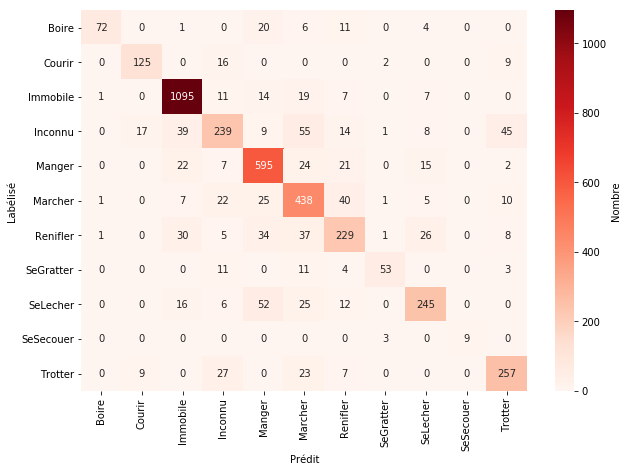

In [218]:
df_cm = pd.DataFrame(Table, index = labels, columns = labels)
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt='g', cmap="Reds")
ax.collections[0].colorbar.set_label("Nombre")
plt.xlabel('Prédit')
plt.ylabel('Labélisé')

Text(69.0, 0.5, 'Labélisé')

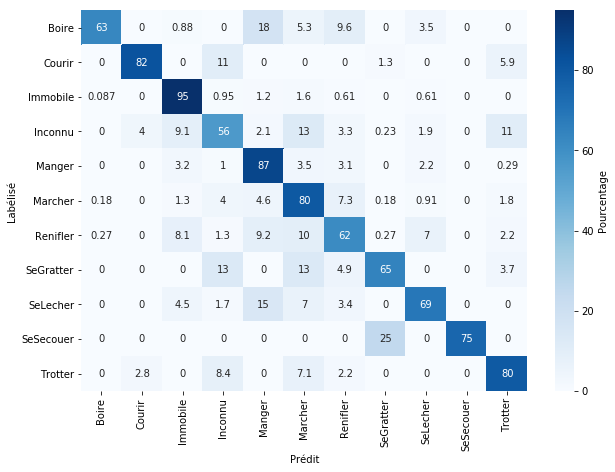

In [219]:
df_cm = pd.DataFrame(100*Table_normal, index = labels, columns = labels)
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap="Blues")
ax.collections[0].colorbar.set_label("Pourcentage")
plt.xlabel('Prédit')
plt.ylabel('Labélisé')

In [220]:
taux_erreur_non_pondere = 100-sum(np.diagonal(100*Table_normal))/Table_normal.shape[0]
print("Sans tenir compte du poids de chaque label l'erreur est de : %.2f pourcent." %(taux_erreur_non_pondere))

Sans tenir compte du poids de chaque label l'erreur est de : 26.13 pourcent.


<a id='section6.5'></a>
## 6.5 Importance des variabes
<a href='#top'> Sommaire</a> <br/>

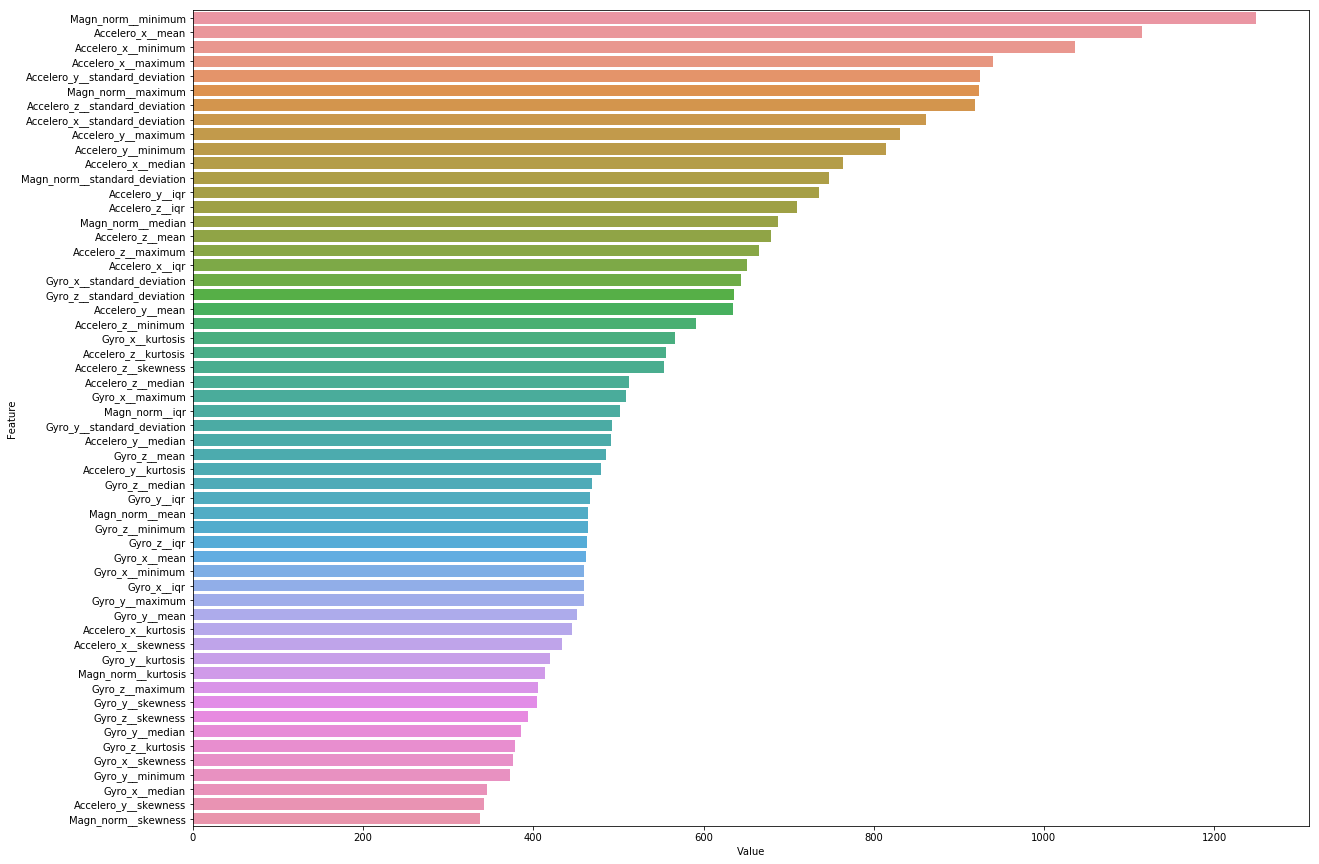

In [230]:
feature_imp = pd.DataFrame(sorted(zip(class_lgb.feature_importances_,XTrain.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))

plt.savefig('Images/lgbm_V_importances-01.png')

In [80]:
moyenne = df_gb.mean()
moyenne.columns = "moyenne : " + moyenne.columns
print(moyenne.shape)

medianne = df_gb.median()
medianne.columns = "medianne : " + medianne.columns
print(medianne.shape)

minimum = df_gb.min()
minimum.columns = "minimum : " + minimum.columns
print(minimum.shape)

maximum = df_gb.max()
maximum.columns = "maximum : " + maximum.columns
print(maximum.shape)

ecart_type = df_gb.std()
ecart_type.columns = "ecart_type : " + ecart_type.columns
print(ecart_type.shape)

asymetrie = df_gb.skew()
asymetrie.columns = "ecart_type : " + ecart_type.columns
print(ecart_type.shape)

result = pd.concat([moyenne, medianne, minimum, maximum, ecart_type], axis=1, join_axes=[moyenne.index])
print(result.shape)

(21126, 7)
(21126, 7)
(21126, 7)
(21126, 7)
(21126, 7)
(21126, 35)


In [79]:
result.head()

moyenne : Accelero_x  moyenne : Accelero_y  \
block Dogs  Behaviour                                               
1     Ambre SeSecouer             -0.097952              0.895194   
2     Athos SeSecouer             -0.099090              0.173682   
3     Athos SeSecouer             -0.271774              0.764038   
4     Baila SeSecouer             -0.115890              0.296408   
5     Belle SeSecouer             -0.446714              0.479844   

                       moyenne : Accelero_z  moyenne : Gyro_x  \
block Dogs  Behaviour                                           
1     Ambre SeSecouer             -1.069642          0.110900   
2     Athos SeSecouer             -3.049104         -0.594398   
3     Athos SeSecouer             -3.907072         -0.373972   
4     Baila SeSecouer             -2.026446          0.026222   
5     Belle SeSecouer             -1.015198          0.347184   

                       moyenne : Gyro_y  moyenne : Gyro_z  \
block Dogs  Behaviour                                       
1     Ambre SeSecouer         -0.039696          0.074798   
2     Athos SeSecouer         -0.242900          0.209308   
3     Athos SeSecouer         -0.035660          0.152456   
4     Baila SeSecouer         -0.229624          0.300196   
5     Belle SeSecouer          0.160436          0.105298   

                       moyenne : Magn_norm  medianne : Accelero_x  \
block Dogs  Behaviour                                               
1     Ambre SeSecouer             0.213648               -0.11350   
2     Athos SeSecouer             0.016052               -0.43155   
3     Athos SeSecouer             0.019214               -0.32060   
4     Baila SeSecouer             0.068146                0.06650   
5     Belle SeSecouer             0.141714               -0.31555   

                       medianne : Accelero_y  medianne : Accelero_z  ...  \
block Dogs  Behaviour                                                ...   
1     Ambre SeSecouer                0.52535               -0.88450  ...   
2     Athos SeSecouer                0.53235               -3.83695  ...   
3     Athos SeSecouer                1.02505               -4.96180  ...   
4     Baila SeSecouer               -0.32395               -1.33570  ...   
5     Belle SeSecouer                0.39915               -0.65335  ...   

                       minimum : Gyro_y  minimum : Gyro_z  \
block Dogs  Behaviour                                       
1     Ambre SeSecouer           -1.1782           -1.2109   
2     Athos SeSecouer           -5.3237           -1.8450   
3     Athos SeSecouer           -5.3984           -2.7549   
4     Baila SeSecouer           -1.5591           -1.2297   
5     Belle SeSecouer           -4.2439           -2.5696   

                       minimum : Magn_norm  maximum : Accelero_x  \
block Dogs  Behaviour                                              
1     Ambre SeSecouer               0.1453               -2.2625   
2     Athos SeSecouer               0.0019               -8.0000   
3     Athos SeSecouer               0.0032               -7.4517   
4     Baila SeSecouer               0.0636               -3.5159   
5     Belle SeSecouer               0.0911               -8.0000   

                       maximum : Accelero_y  maximum : Accelero_z  \
block Dogs  Behaviour                                               
1     Ambre SeSecouer               -5.3428               -4.2852   
2     Athos SeSecouer               -8.0000               -8.0000   
3     Athos SeSecouer               -8.0000               -8.0000   
4     Baila SeSecouer               -6.0391               -8.0000   
5     Belle SeSecouer               -5.7688               -7.7788   

                       maximum : Gyro_x  maximum : Gyro_y  maximum : Gyro_z  \
block Dogs  Behaviour                                                         
1     Ambre SeSecouer           -4.1797           -1.1782           -1.2109   
2     Athos 

In [70]:
"moyenne : " + moyenne.columns

Index(['moyenne : Accelero_x', 'moyenne : Accelero_y', 'moyenne : Accelero_z',
       'moyenne : Gyro_x', 'moyenne : Gyro_y', 'moyenne : Gyro_z',
       'moyenne : Magn_norm'],
      dtype='object')

In [ ]:
# mean
# median
.median()
# min
# max
.max()
# std
.std()
.skew()

In [53]:
test2.mean()

Accelero_x  Accelero_y  Accelero_z    Gyro_x  \
block Dogs    Behaviour                                                 
1     Ambre   SeSecouer   -0.097952    0.895194   -1.069642  0.110900   
2     Athos   SeSecouer   -0.099090    0.173682   -3.049104 -0.594398   
3     Athos   SeSecouer   -0.271774    0.764038   -3.907072 -0.373972   
4     Baila   SeSecouer   -0.115890    0.296408   -2.026446  0.026222   
5     Belle   SeSecouer   -0.446714    0.479844   -1.015198  0.347184   
6     Belle   SeSecouer    0.055320    0.487250   -1.143168  0.150416   
7     Canelle SeSecouer   -0.357312    0.023314   -2.369966  0.041732   
8     Cookie1 SeSecouer    0.038682   -0.448458   -1.166892  0.043728   
9     Cookie1 SeSecouer    0.173582   -0.327452   -1.138944  0.125136   
10    Cookie1 SeSecouer    0.092336   -0.393558   -1.212930 -0.017240   
11    Cookie1 SeSecouer    0.056592   -0.016378   -1.502822 -0.183264   
12    Curtis  SeSecouer   -0.250380    0.770832   -3.808862  0.323018   
13    Curtis  SeSecouer   -0.039166   -0.162928   -2.105196 -0.002344   
14    Curtis  SeSecouer   -0.086490   -0.366794   -2.852036 -0.278164   
15    Curtis  SeSecouer   -0.092004   -0.168128   -2.635356  0.112188   
16    Curtis  SeSecouer    0.065382   -0.188836   -1.511866  0.016612   
17    Eva2    SeSecouer   -0.425770   -0.751588   -1.526562 -0.145800   
18    Fly     SeSecouer    0.331056    0.430518   -1.841026  0.064012   
19    Gatchan SeSecouer    0.478066    0.805740   -2.399584 -0.256580   
20    Gatchan SeSecouer    0.540052    1.120160   -5.248194 -0.065314   
21    Gatchan SeSecouer    0.514100    0.554536   -2.410280 -0.144634   
22    Gatchan SeSecouer    0.235434    0.610744   -3.626080  0.001134   
23    Gatchan SeSecouer    0.216318    0.201826   -1.936414 -0.212766   
24    Ines    SeSecouer   -0.432838    0.538260   -1.516568 -0.582558   
25    Irish   SeSecouer    0.101352   -0.932748   -1.162678 -0.046994   
26    Joey    SeSecouer   -0.155428   -0.730774   -2.497374  0.135418   
27    Joey    SeSecouer    0.172066   -0.497056   -2.559054  0.124142   
28    Joey    SeSecouer    0.101008   -0.860418   -2.598598  0.248018   
29    Joey    SeSecouer   -0.132982   -0.860062   -1.975412  0.110072   
30    Joey    SeSecouer   -0.165040   -0.873654   -0.983452  0.053318   
...                             ...         ...         ...       ...   
21097 Shadow  SeLecher    -0.388724   -0.012146   -0.930544  0.003836   
21098 Shadow  SeLecher    -0.382612   -0.021770   -0.937136 -0.001008   
21099 Shadow  SeLecher    -0.378664   -0.016584   -0.938042  0.006010   
21100 Shadow  SeLecher    -0.374222   -0.015126   -0.941386  0.003564   
21101 Shadow  SeLecher    -0.377256   -0.019032   -0.938066  0.006746   
21102 Shadow  SeLecher    -0.385898    0.002420   -0.930208 -0.000662   
21103 Shadow  SeLecher    -0.389142    0.000106   -0.944982 -0.001786   
21104 Shadow  SeLecher    -0.530436    0.034516   -0.825154  0.003256   
21105 Shadow  SeLecher    -0.517618    0.054570   -0.847006  0.001536   
21106 Shadow  SeLecher    -0.463900    0.029426   -0.875216  0.010972   
21107 Shadow  SeLecher    -0.411078    0.021236   -0.916862  0.004266   
21108 Shadow  SeLecher    -0.391370    0.008942   -0.929710  0.000798   
21109 Shadow  SeLecher    -0.363100    0.016484   -0.941308  0.002820   
21110 Shadow  SeLecher    -0.366506    0.000986   -0.938206  0.004804   
21111 Shadow  SeLecher    -0.368188   -0.008968   -0.948500  0.002716   
21112 Shadow  SeLecher    -0.517138    0.026130   -0.840774 -0.003292   
21113 Shadow  SeLecher    -0.403424   -0.035092   -0.919542  0.006166   
21114 Shadow  SeLecher    -0.282304   -0.130556   -0.980396  0.018188   
21115 Shadow  SeLecher    -0.295206   -0.149022   -0.982042 -0.010800   
21116 Shadow  SeLecher    -0.336178   -0.131694   -0.949182  0.006810   
21117 Shadow  SeLecher    -0.297028   -0.231252   -0.970932  0.031374   
21118 Shadow  SeLecher    -0.372836   -0.319692   -0.899804 -0.051500   
21119 Shad

In [15]:
df_block = df_paquets.groupby(['block']).mean()

In [16]:
df_block.head()

id_brut    Time_Debut  Accelero_x  Accelero_y  Accelero_z  \
block                                                                    
0      600579.673049  48354.435606   -0.296862   -0.019857   -0.674083   
1       22250.500000  73053.000000   -0.097952    0.895194   -1.069642   
2       25976.500000   5349.000000   -0.099090    0.173682   -3.049104   
3       35623.500000  33421.000000   -0.271774    0.764038   -3.907072   
4       76940.500000  34823.000000   -0.115890    0.296408   -2.026446   

         Gyro_x    Gyro_y    Gyro_z  Magn_norm   c_chien     c_beh     ecart  \
block                                                                          
0      0.001470 -0.000868  0.001899   0.175265  0.999933  0.994441 -1.460333   
1      0.110900 -0.039696  0.074798   0.213648  1.000000  0.980000  3.680000   
2     -0.594398 -0.242900  0.209308   0.016052  1.000000  1.000000  2.960000   
3     -0.373972 -0.035660  0.152456   0.019214  1.000000  0.980000  5.920000   
4      0.026222 -0.229624  0.300196   0.068146  1.000000  0.980000  3.960000   

       double_label  
block                
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [18]:
df_block.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21127 entries, 0 to 21126
Data columns (total 13 columns):
id_brut         21127 non-null float64
Time_Debut      21127 non-null float64
Accelero_x      21127 non-null float32
Accelero_y      21127 non-null float32
Accelero_z      21127 non-null float32
Gyro_x          21127 non-null float32
Gyro_y          21127 non-null float32
Gyro_z          21127 non-null float32
Magn_norm       21127 non-null float32
c_chien         21127 non-null float64
c_beh           21127 non-null float64
ecart           21127 non-null float64
double_label    21127 non-null float64
dtypes: float32(7), float64(6)
memory usage: 1.7 MB


In [ ]:
list_beh = [u'SeSecouer', u'Trotter', u'Immobile', u'Marcher', u'Manger',
       u'Boire', u'Renifler', u'SeGratter', u'SeLecher', u'Courir', u'Inconnu'] 

# List initial features
list_col   = ['Accelero_x', 'Accelero_y', 'Accelero_z', 'Gyro_x','Gyro_y', 'Gyro_z','Magn_norm']

def feature_engineering(df):


    # init counter
    j = 0

    for i in list_col:

        if j == 0:

            # mean
            df_mean = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].mean()).reset_index(drop = False)
            df_mean.columns = ['index','Type','Behaviour','Dogs',str(i) + '_mean']

            # median
            df_median = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].median()).reset_index(drop = False)
            df_median.columns = ['index','Type','Behaviour','Dogs',str(i) + '_med']

            # min
            df_min = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].min()).reset_index(drop = False)
            df_min.columns = ['index','Type','Behaviour','Dogs',str(i) + '_min']

            # max
            df_max = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].max()).reset_index(drop = False)
            df_max.columns = ['index','Type','Behaviour','Dogs',str(i) + '_max']

            # std
            df_std = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].std()).reset_index(drop = False)
            df_std.columns = ['index','Type','Behaviour','Dogs',str(i) + '_std']

            # skew
            df_skew = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].skew()).reset_index(drop = False)
            df_skew.columns = ['index','Type','Behaviour','Dogs',str(i) + '_skew']

            # kurtosis
            df_kurt = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].apply(pd.Series.kurtosis)).reset_index(drop = False)
            df_kurt.columns = ['index','Type','Behaviour','Dogs',str(i) + '_kurt']

            # iqr
            df_iqr = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].apply(sc.stats.iqr)).reset_index(drop = False)
            df_iqr.columns = ['index','Type','Behaviour','Dogs',str(i) + '_iqr']

            df_init = df_mean.merge(df_median).merge(df_min).merge(df_max).merge(df_std).merge(df_skew).merge(df_kurt).merge(df_iqr)

        if j >= 1:

            #mean
            stag_mean = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].mean()).reset_index(drop = False)
            stag_mean.columns = ['index','Type','Behaviour','Dogs', str(i) + '_mean']

            # med
            stag_median = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].median()).reset_index(drop = False)
            stag_median.columns = ['index','Type','Behaviour','Dogs', str(i) + '_med']

            # min
            stag_min = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].min()).reset_index(drop = False)
            stag_min.columns = ['index','Type','Behaviour','Dogs', str(i) + '_min']

            # max
            stag_max = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].max()).reset_index(drop = False)
            stag_max.columns = ['index','Type','Behaviour','Dogs', str(i) + '_max']

            # std
            stag_std = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].std()).reset_index(drop = False)
            stag_std.columns = ['index','Type','Behaviour','Dogs', str(i) + '_std']

            # skew
            stag_skew = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].skew()).reset_index(drop = False)
            stag_skew.columns = ['index','Type','Behaviour','Dogs', str(i) + '_skew']

            # kurt
            stag_kurt = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].apply(pd.Series.kurtosis)).reset_index(drop = False)
            stag_kurt.columns = ['index','Type','Behaviour','Dogs', str(i) + '_kurt']

            # iqr
            stag_iqr = pd.DataFrame(df.groupby(['index','Type','Behaviour','Dogs'])[str(i)].apply(sc.stats.iqr)).reset_index(drop = False)
            stag_iqr.columns = ['index','Type','Behaviour','Dogs', str(i) + '_iqr']

            # join
            df_init = df_init.merge(stag_mean).merge(stag_median).merge(stag_min).merge(stag_max).merge(stag_std).merge(stag_skew).merge(stag_kurt).merge(stag_iqr)

        # Counter
        j = j + 1
        
    df_init.fillna(0, inplace = True)
    
    return df_init

df = feature_engineering(df, 50)